# PINNs (Physics Informed Neural Networks)
---

This is an implentation of a physics informed neural network, to solve the logistic equation in pytorch, a PINN works by defining a function $f$ which is a neural network, and a loss function such that when the loss function is minimized $f$ is approximetly equal to the solution of the differential equation 

##Required libraries
- pytorch
- numpy
- scipy (ODE Solver for comparision)
- matplotlib (Drawing graphs)



In [ ]:
# import libraries
from torch import nn as nn
import torch
import torch.autograd as ag
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import odeint

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


#Defining the diffrential equation
---

For this implementation I have decide to solve the following equation this servers mostly as an example problem to learn about PINN and how they work

## Equation
$$
    \frac{d^2f}{dt} + \frac{df}{dt} + f = 0
$$
With Initial Condition
- $f(0) = 1$
- $\frac{df}{dt}(0) = 0$

_I am not sure if an analytic solution exist, therefore I will use Runga Kutta Order 4 (RK) to approximate the solution and generate some training data as well as comparision_

To use RK the equation needs to be converted to a system of 1st order ODE's as follow

$$
    \text{let } u_1 = f \\
    \text{let } u_2 = \frac{du_1}{dt} = \frac{df}{dt} \\
$$
Therefore
$$
    \frac{du_1}{dt} = u_2 \\
    \frac{du_2}{dt} = -u_1 - u_2
$$
Written as a Matrix
$$
    \pmatrix{
        \frac{du_1}{dt} \\
        \frac{du_2}{dt}
    } = 
    \pmatrix{
        0  &  1 \\
        -1 & -1
    } \cdot \pmatrix{u_1 \\ u_2}
$$


In [ ]:
}def DE(x,t):
    M = np.array([[ 0,   1],
                  [-1, -1]])
    
    return M @ x

def RK(x):
    y0 = np.array([1,0])
    y  = odeint(DE, y0, x)
    return y[:,0]

#Defining the neural Network architecture
---

The neural network consists of a simple fully connected layer with 1 input and 1 output since this an ODE (Odinary differential equation) this neural network plays the role of function $f$ as mentioned above


In [ ]:
class ApproximatorNet(nn.Module):
    def __init__(self, input_size: int = 1, output_size: int = 1, hidden_layers: int = 5, hidden_nodes: int = 10) -> None:
        """
            Builds an neural network to approximate the value of the differential equation
            input_size must be set to number of parameters in the function f for ODE this is 1
            output_size number of values output by the function for ODE this is 1
        """
        super().__init__()
        
        self.inputs  = nn.Linear(input_size, hidden_nodes)
        self.model   = nn.ModuleList([nn.Linear(hidden_nodes, hidden_nodes)] * hidden_layers)
        self.outputs = nn.Linear(hidden_nodes, output_size) 
        
        self.activation = nn.Tanh() # Can be either tanh or sigmoid, ReLU is not differentiable everywhere, I think
    
    def _apply_model(self, x: torch.Tensor) -> torch.Tensor:
        """
            Runs the input through the hidden layers
        """
        for layer in self.model:
            x = self.activation(layer(x))
        return x

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        t = self.activation(self.inputs(t))
        t = self._apply_model(t)
        t = self.outputs(t)
        return t



## Generating the training data

- $x$ is the full, high resolution set of evaluation points
- $y$ is the actual solution, for comparision 
- $x_{data}$ and $y_{data}$ are the set of training points used to train the model note that these training points are usually generated by means expirements and need not be from an existing algorithm, as shown here

- $x_{physics}$ is the set of points used to calculate the physics loss (loss with respect to the governing equation)

In [ ]:
x = np.linspace(0,5,500)
y = RK(x)

x = x.reshape(-1,1)
y = y.reshape(-1,1)

x_data = x[0:200:20]
y_data = y[0:200:20]

print(x_data.shape, y_data.shape)

x_data_t = torch.tensor(x_data, dtype =torch.float32, device="cuda")
y_data_t = torch.tensor(y_data, dtype =torch.float32, device="cuda")

x_physics = torch.linspace(0, 5, 100, requires_grad=True, device="cuda", dtype=torch.float32).reshape(-1,1)

## Setting up the hyper parameters and traing

### Loss Function

This part follows standard procedures to train a neural network, except the loss function is made up of 2 parts ${loss}_u$ which denotes the data loss (loss with respect to the data points) and ${loss}_f$ which denotes the physics loss, the losses are calulated as follows. the total loss of the model is a sum of these 2 losses

$$
    {loss}_u = \frac{1}{n}\sum_{i=0}^{n}{(f(x_{data}) - y_{data})^2}
$$

and

$$
    {loss_f} = \frac{1}{n_p}\sum_{i=0}^{n_p}{ψ(x_{i})}
$$

where

- $n = $ number of data points
- $n_p = $ number of physics evalutaion points or $len(x_{physics})$
- $\psi = $ is a function representing the diffrential equation

### Model architecture

The model architecture used is a simple fully connected neural network with 1 input (_Since this is an ODE_) and 1 output, there are 15 hidden layers each consisting of 32 neurons 

---

*Note: Original implementation used L-BFGS as the optimizer*

In [ ]:
# Hyperparameters
EPOCHS = 20_000
LR = 1e-4

model = ApproximatorNet(hidden_layers=15, hidden_nodes=32).to('cuda')
optim = torch.optim.Adam(model.parameters(), lr=LR)
data_loss = nn.MSELoss()

for epoch in range(EPOCHS):
    optim.zero_grad()
    
    # Compute the "data loss"
    y_pred = model(x_data_t)
    loss_u = data_loss(y_pred, y_data_t)
    
    # Compute the Derivates of the model WRT inputs
    u   = model(x_physics)
    du  = ag.grad(u, x_physics, torch.ones_like(u), create_graph=True)[0]
    ddu = ag.grad(du,  x_physics, torch.ones_like(du),  create_graph=True)[0]

    # Compute the physics loss
    physics = ddu + du + u
    loss_f = torch.mean(physics**2)
    
    # backpropagate joint loss
    loss = loss_u + loss_f # add two loss terms together
    loss.backward()
    optim.step()
    
    if epoch % 1000 == 0:
        print(f"Epochs = {epoch} of {EPOCHS}, Loss = {float(loss):.7f}")

(10, 1) (10, 1)
Epochs = 0 of 20000, Loss = 0.6513011
Epochs = 1000 of 20000, Loss = 0.0219624
Epochs = 2000 of 20000, Loss = 0.0132998
Epochs = 3000 of 20000, Loss = 0.0061515
Epochs = 4000 of 20000, Loss = 0.0033055
Epochs = 5000 of 20000, Loss = 0.0019824
Epochs = 6000 of 20000, Loss = 0.0013155
Epochs = 7000 of 20000, Loss = 0.0009150
Epochs = 8000 of 20000, Loss = 0.0002051
Epochs = 9000 of 20000, Loss = 0.0000967
Epochs = 10000 of 20000, Loss = 0.0000403
Epochs = 11000 of 20000, Loss = 0.0000310
Epochs = 12000 of 20000, Loss = 0.0000255
Epochs = 13000 of 20000, Loss = 0.0000214
Epochs = 14000 of 20000, Loss = 0.0000184
Epochs = 15000 of 20000, Loss = 0.0000157
Epochs = 16000 of 20000, Loss = 0.0000137
Epochs = 17000 of 20000, Loss = 0.0001432
Epochs = 18000 of 20000, Loss = 0.0000105
Epochs = 19000 of 20000, Loss = 0.0000091


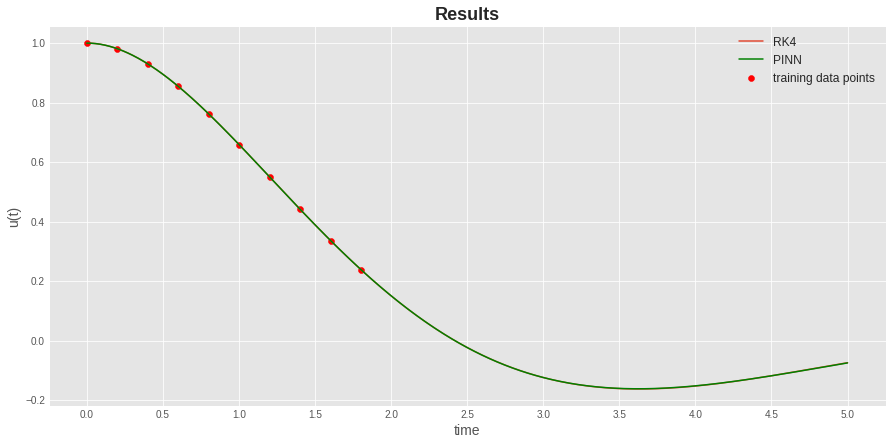

In [ ]:
model.eval()
y_pred = model(torch.tensor(x, dtype = torch.float32, device="cuda").reshape(-1,1))
y_pred = y_pred.detach().cpu().numpy().reshape(-1,)

title_font = {
    "fontsize" : 18,
    "fontweight": "bold"
} 

plt.figure(figsize=(15, 7))
plt.style.use("ggplot")
plt.xticks(np.arange(0, 5.5, step=0.5))
plt.title("Results", title_font)
plt.plot(x, y, label="RK4")
plt.xlabel("time", fontsize=14)
plt.plot(x, y_pred, label="PINN", c="g")
plt.ylabel("u(t)", fontsize=14)
plt.scatter(x_data.reshape(-1,), y_data.reshape(-1,), c="r", label="training data points")
plt.legend(fontsize="large")
plt.savefig("2nd-Order-ODE.svg")
plt.show()

In [ ]:
PATH = f"2ndOrderModel.pt"
torch.save(model.state_dict(), PATH)
